# Rossmann Store Sales Forecasting - Store 2

This notebook builds a SARIMAX model to forecast daily sales for Store 2, incorporating weekly seasonality and the effects of promotions and holidays.

In [1]:
# ## 1. Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
import math
# No need to import auto_arima in the final script unless re-running selection

# Set plotting styles
sns.set(style='darkgrid')
plt.rcParams['figure.figsize'] = (14, 7)

## 2. Load and Prepare Data
Load `train.csv` and `store.csv`, merge them, handle date format, filter for **Store 2**, remove closed days, and set date as index.

In [2]:
# Load the datasets
try:
    train_df = pd.read_csv('../data/train.csv', low_memory=False)
    store_df = pd.read_csv('../data/store.csv')
except FileNotFoundError:
    print("Error: train.csv or store.csv not found in the '../data/' folder.")
    # Handle error appropriately

# Merge, convert date, sort
df = pd.merge(train_df, store_df, on='Store')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', inplace=True)

# <<< --- Filter for Store 2 --- >>>
store_id = 2
# <<< ------------------------ >>>
df_store = df[(df['Store'] == store_id) & (df['Sales'] > 0)].copy()
df_store.set_index('Date', inplace=True)

print(f"Data prepared for Store {store_id}. Shape: {df_store.shape}")
df_store.head()

Data prepared for Store 2. Shape: (784, 17)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Date,,,,,,,,,,,,,,,,,
2013-01-02,2,3,4422,650,1,0,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2013-01-03,2,4,4159,555,1,0,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2013-01-04,2,5,4484,574,1,0,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2013-01-05,2,6,2342,324,1,0,0,0,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2013-01-07,2,1,6775,763,1,1,0,0,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


## 3. Exploratory Data Analysis (EDA) & Seasonality Check
Visualize sales data for Store 2 to identify trends and seasonality.

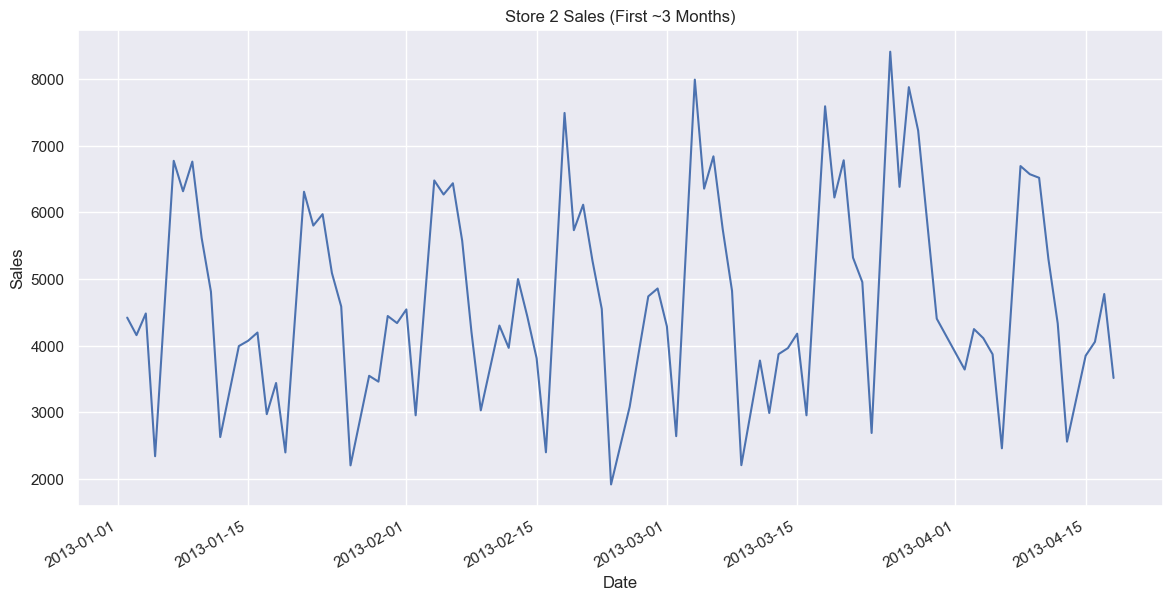

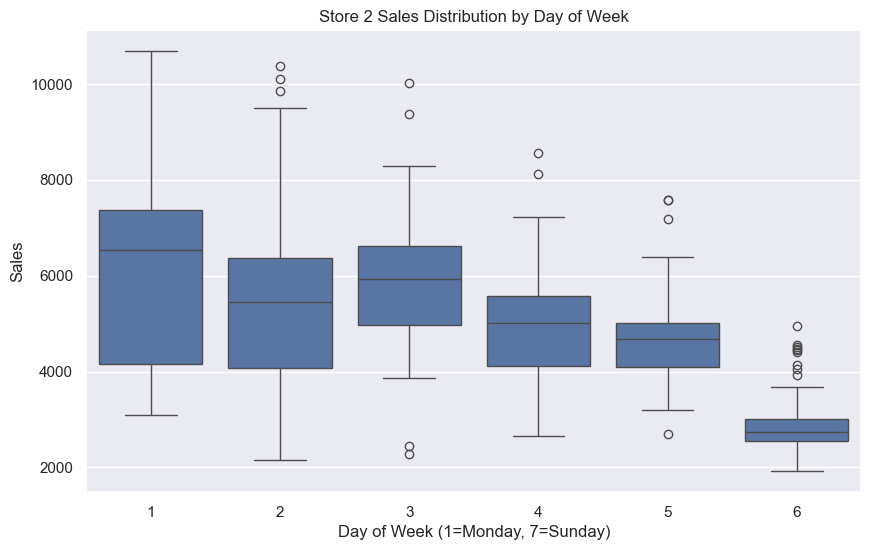

<Figure size 1200x600 with 0 Axes>

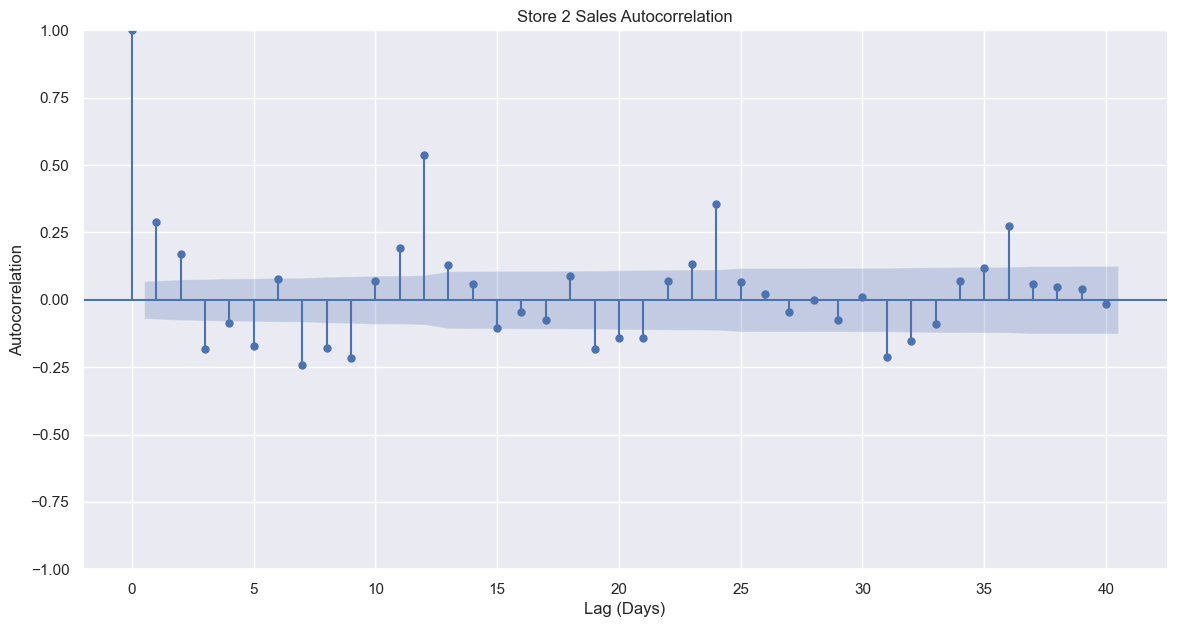

In [3]:
# Plot sales over time (zoomed view)
df_store['Sales'].iloc[:90].plot() # Plot first ~3 months
plt.title(f'Store {store_id} Sales (First ~3 Months)')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.show()

# Box plot by day of week
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_store, x='DayOfWeek', y='Sales')
plt.title(f'Store {store_id} Sales Distribution by Day of Week')
plt.xlabel('Day of Week (1=Monday, 7=Sunday)')
plt.ylabel('Sales')
plt.show()

# Autocorrelation Function (ACF) plot
plt.figure(figsize=(12, 6))
plot_acf(df_store['Sales'], lags=40, title=f'Store {store_id} Sales Autocorrelation')
plt.xlabel('Lag (Days)')
plt.ylabel('Autocorrelation')
plt.show()

**EDA Analysis (Store 2):**
- The plots confirm a **strong 7-day weekly seasonality** (highest sales on Mondays, dips mid-week).
- The ACF plot shows **significant peaks at lags 7, 14, etc.**, confirming the weekly cycle (`m=7`).
- The ACF also shows **slow decay** from Lag 1, indicating **non-stationarity** and suggesting **differencing (`d=1`)** is necessary.

## 4. Feature Engineering
Prepare target variable (`y` = Sales) and exogenous variables (`X` = Promo, SchoolHoliday, StateHoliday). Convert `X` to numeric types.

In [4]:
# --- Feature Engineering ---
model_df = df_store.copy()

# Handle StateHoliday (convert '0' string, then one-hot encode)
model_df['StateHoliday'] = model_df['StateHoliday'].replace('0', 0)
model_df['StateHoliday'] = model_df['StateHoliday'].replace(0, 'NoHoliday')
model_df = pd.get_dummies(model_df, columns=['StateHoliday'], drop_first=True)

# Define target variable 'y'
y = model_df['Sales']

# Define exogenous variables 'X'
state_holiday_cols = [col for col in model_df.columns if col.startswith('StateHoliday_')]
exog_cols = ['Promo', 'SchoolHoliday'] + state_holiday_cols
X = model_df[exog_cols]

# Convert X to integer type for statsmodels compatibility
X = X.astype(int)

print(f"Exogenous variables for Store {store_id} (X) head:")
print(X.head())

Exogenous variables for Store 2 (X) head:
            Promo  SchoolHoliday  StateHoliday_a
Date                                            
2013-01-02      0              1               0
2013-01-03      0              1               0
2013-01-04      0              1               0
2013-01-05      0              0               0
2013-01-07      1              0               0


## 5. Train/Test Split
Split data sequentially into training and testing sets.

In [5]:
test_period = 30
train_size = len(y) - test_period

y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]
X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]

print(f"Training data size: {len(y_train)} points")
print(f"Test data size:     {len(y_test)} points")

Training data size: 754 points
Test data size:     30 points


## 6. Model Training (SARIMAX)
**Model Selection Rationale:**
- EDA confirmed weekly seasonality (`m=7`) and non-stationarity (requiring `d=1`).
- `auto_arima` (run separately) suggested complex orders for Store 2, e.g., `(3,1,5)(1,0,0)[7]`.
- However, complex models often lead to convergence issues. Based on experience with Store 1 and prioritizing stability, we chose the simple, robust orders `(1,1,1)x(0,0,1,7)` which successfully converged for Store 1.

In [6]:
# --- Train the Final Stable Model ---
# Orders: (p=1, d=1, q=1) and seasonal (P=0, D=0, Q=1, m=7)
my_order = (1, 1, 1)
my_seasonal_order = (0, 0, 1, 7)

# Create and fit the SARIMAX model
final_model_store2 = sm.tsa.SARIMAX(
    endog=y_train,
    exog=X_train,
    order=my_order,
    seasonal_order=my_seasonal_order
)

print(f"Training final SARIMAX model for Store {store_id} with orders {my_order}x{my_seasonal_order}...")
try:
    model_fit_store2 = final_model_store2.fit(disp=False)
    print("Model training complete.")
    # Print the model summary - Check for ConvergenceWarning
    print(model_fit_store2.summary())
except Exception as e:
    print(f"Error during model fitting: {e}")
    print("Consider simplifying orders further if convergence failed.")

Training final SARIMAX model for Store 2 with orders (1, 1, 1)x(0, 0, 1, 7)...


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model training complete.
                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                  754
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 7)   Log Likelihood               -6281.896
Date:                           Wed, 22 Oct 2025   AIC                          12577.792
Time:                                   22:52:34   BIC                          12610.161
Sample:                                        0   HQIC                         12590.262
                                           - 754                                         
Covariance Type:                             opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Promo           3251.7283    100.590     32.327      0.000    3054.575    3448.881
School

**Model Summary Analysis (Store 2):**
- The model converged successfully using the `(1,1,1)x(0,0,1,7)` orders.
- AIC score is ~12578.
- `Promo`, `SchoolHoliday`, and `StateHoliday_a` are all statistically significant (p < 0.05) predictors of sales *changes* for Store 2.
- The `ma.L1` term is very close to -1, which can sometimes indicate slight instability, but the model did converge. The seasonal `ma.S.L7` term is also significant.

## 7. Forecasting & Evaluation
Generate forecasts on the test set and evaluate performance using plots and metrics (RMSE and RMSPE).

/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


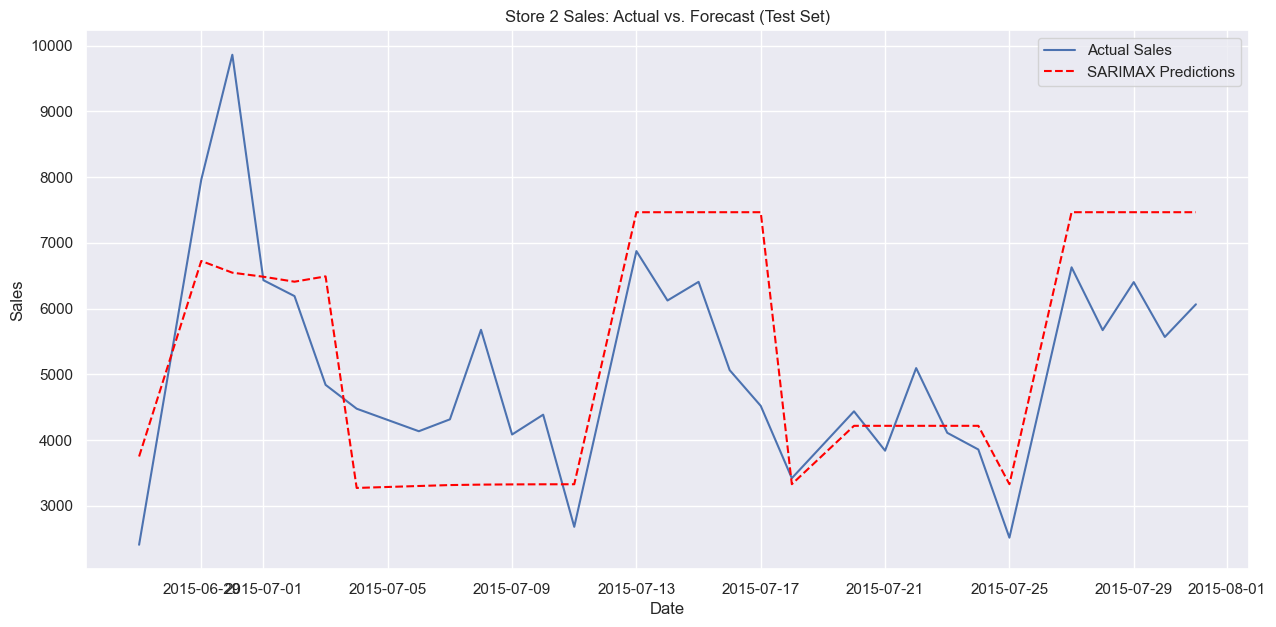

Model Accuracy (RMSE) for Store 2: 1391.65
Model Accuracy (RMSPE) for Store 2: 27.47%


In [7]:
# --- Forecasting ---
num_steps = len(y_test)

# Use the fitted model for Store 2
predictions = model_fit_store2.forecast(steps=num_steps, exog=X_test)
predictions = predictions.rename('SARIMAX Predictions')

# --- Evaluation ---
# Fix index for plotting
try:
    predictions.index = y_test.index
except ValueError as e:
    print(f"Error setting prediction index: {e}. Lengths: y_test={len(y_test)}, predictions={len(predictions)}")

# Plot actual vs. predicted
plt.figure(figsize=(15, 7))
plt.plot(y_test, label='Actual Sales')
plt.plot(predictions, label='SARIMAX Predictions', color='red', linestyle='--')
plt.title(f'Store {store_id} Sales: Actual vs. Forecast (Test Set)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Calculate metrics
rmse = math.sqrt(mean_squared_error(y_test, predictions))

# Ensure no zero division for RMSPE
y_test_safe = y_test.replace(0, np.nan).dropna()
predictions_safe = predictions.loc[y_test_safe.index] # Ensure alignment
rmspe = np.sqrt(np.mean(((y_test_safe - predictions_safe) / y_test_safe) ** 2))

print(f"Model Accuracy (RMSE) for Store {store_id}: {rmse:.2f}")
print(f"Model Accuracy (RMSPE) for Store {store_id}: {rmspe * 100:.2f}%")

**Evaluation Analysis (Store 2):**
- The plot shows the forecast follows the general weekly pattern but under-predicts the peaks significantly.
- The **RMSPE of ~27.47%** is considerably higher than for Store 1 (~12%), indicating lower accuracy for this store with this simple model structure. This highlights the store-specific nature of sales patterns. Further tuning or different model orders might improve results for Store 2.